In this notebook, we discuss how to read the result of RUL prediction for predictive maintenance planning. The RUL prediction is conducted in the two notebooks:

- rul_reg.ipynb for regression model
- rul_pf_battery.ipynb for particle filtering

If you run the notebooks, you will get the results in the 12 .pickle files. To read the result, you can use the code below:

In [1]:
import numpy as np
import pickle
import pandas as pd


battery_list = ['CS2_33', 'CS2_34', 'CS2_35', 'CS2_36', 'CS2_37', 'CS2_38']
# Read the first battery:
name = battery_list[1]
# Get the file names
file_name = 'result_reg_' + name + '.pickle'
# Read the data
with open(file_name, 'rb') as f:
    [t, y, threshold, idx_ttf, idx_pred, true_ttf, max_RUL, 
        x_hat, yh, y_bands, rul_mean, rul_bands, rul, x_sample
    ] = pickle.load(f)

This is for the regression model. For the results of particle filtering, you just need to replace the file_name to be:
file_name = 'result_' + name + '.pickle'

The main results are stored in the variable rul.

In [2]:
rul.shape

(1000, 31)

You can see that rul is a matrix of 1000*31. Each column is a vector containing the bootstrap samples of RUL prediction, predicted at a specific time instant. We have $31$ column in this case, because the RUL prediciton start from $310$ cycles before time to failure, and the prediction is done every $10$ cycles. To get the time instants when the RUL prediction is conducted, we can use "idx_pred": 

In [3]:
# Get the time instants when the RUL prediction is conducted.
t_pred = t[idx_pred]

Here, we can try to plan preventive maintenance at any prediciton time instant. For example, for the first prediction point:

t_cur = 350.0
ttf = 650.0
T*_a = 399.9999845215417
Optimal expected cost rate: 0.002500000096740368


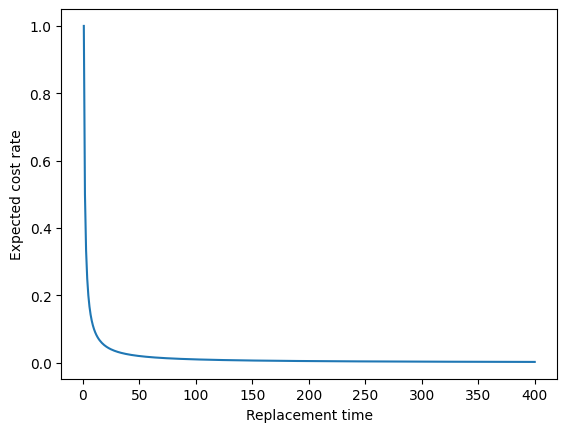

In [4]:
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt

i = 0

t_search = np.linspace(1, 400, 400) # We define the search region.
t_cur = t_pred[i] # Get the current time.
rul_bs = rul[:, i] # Get the result of RUL prediction.

# Define cost rate
c_1 = 100
c_2 = 1
# cal_cr = lambda t: (c_1*sum(rul_bs<t)/len(rul_bs) + c_2*(sum(rul_bs>=t)/len(rul_bs)))/(t_cur + np.concatenate([rul_bs[rul_bs<t], t*np.ones_like(rul_bs[rul_bs>=t])]).mean()) # Age replacement
cal_cr = lambda t: (c_1*sum(rul_bs<t)/len(rul_bs) + c_2)/(t) # Block replacement

# Show cost rate V.S. time
cr = []
for t_run in t_search:
  cr.append(cal_cr(t_run))

# Visualize the results.
axis = plt.subplot()
plt.plot(t_search, cr, '-')
axis.set_xlabel('Replacement time')
axis.set_ylabel('Expected cost rate')

# Run an optimization to get the optimal preventive maintenance time.
result_a = minimize_scalar(cal_cr, bounds=(1, 400), method='bounded')
print('t_cur = {}'.format(t_cur))
print('ttf = {}'.format(true_ttf))
print('T*_a = ' + str(result_a.x))
print('Optimal expected cost rate: ' + str(result_a.fun))

Since the optimal preventive maintenance time is after the next prediction point, we actually do not execute this operation, but wait until collecting the new condition-monitoring data to update our RUL prediciton.

When the optimal preventive time falls before the next prediction instant, this maintenance operation will be executed. For example, in the case below, we will make a preventive replacement after $7.56$ units of time.

t_cur = 610.0
ttf = 650.0
T*_a = 14.68943953555228
Optimal expected cost rate: 0.06807611669456407


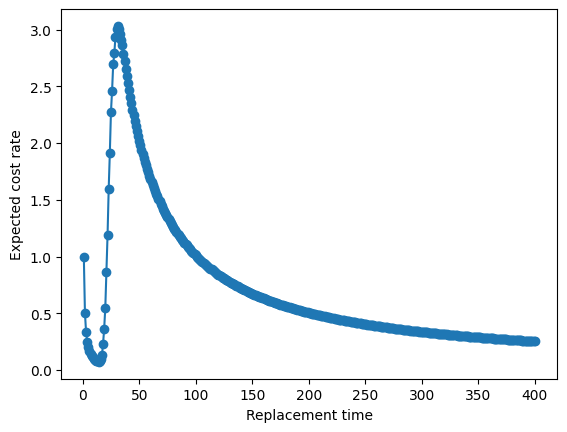

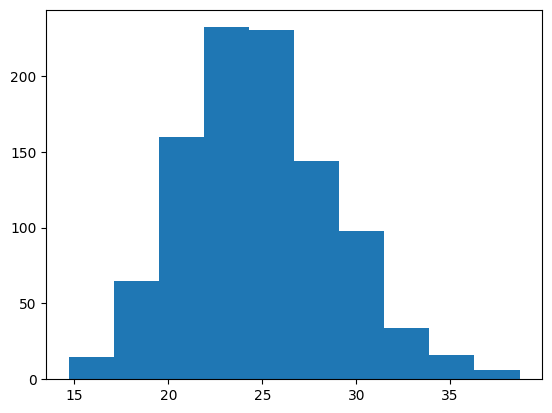

In [9]:
i = 10

t_search = np.linspace(1, 400, 400) # We define the search region.
t_cur = t_pred[i] # Get the current time.
rul_bs = rul[:, i] # Get the result of RUL prediction.

# Define cost rate
c_1 = 100
c_2 = 1
# cal_cr = lambda t: (c_1*sum(rul_bs<t)/len(rul_bs) + c_2*(sum(rul_bs>=t)/len(rul_bs)))/(np.concatenate([rul_bs[rul_bs<t], t*np.ones_like(rul_bs[rul_bs>=t])]).mean()) # Age replacement
cal_cr = lambda t: (c_1*sum(rul_bs<t)/len(rul_bs) + c_2)/(t) # Block replacement

# Show cost rate V.S. time
cr = []
for t_run in t_search:
  cr.append(cal_cr(t_run))

# Visualize the results.
axis = plt.subplot()
plt.plot(t_search, cr, '-o')
axis.set_xlabel('Replacement time')
axis.set_ylabel('Expected cost rate')

axis = plt.figure()
plt.hist(rul_bs)

# Run an optimization to get the optimal preventive maintenance time.
result_a = minimize_scalar(cal_cr, bounds=(1, 20), method='bounded')
print('t_cur = {}'.format(t_cur))
print('ttf = {}'.format(true_ttf))
print('T*_a = ' + str(result_a.x))
print('Optimal expected cost rate: ' + str(result_a.fun))